In [ ]:
] activate ../

In [1]:
] status

Project TopographicHorizontalConvection v0.1.0
Status `/dfs6/pub/ikeshwan/code/HorizontalConvection/Project.toml`
⌃ [13f3f980] CairoMakie v0.12.1
  [7073ff75] IJulia v1.24.2
  [a98d9a8b] Interpolations v0.15.1
⌅ [85f8d34a] NCDatasets v0.12.17
  [b946abbf] NaNStatistics v0.6.35
⌃ [9e8cae18] Oceananigans v0.88.0
  [de0858da] Printf
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [1]:
using Oceananigans
#using Printf

In [2]:
Nx = 60 # Difference from Nz to spot any errors
Nz = 48
L = 10
H = 8
grid = RectilinearGrid(size=(Nx, Nz), x=(-L/2, L/2), z=(-H/2, H/2),
                       topology=(Periodic, Flat, Bounded))

60×1×48 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── Periodic x ∈ [-5.0, 5.0)      regularly spaced with Δx=0.166667
├── Flat y
└── Bounded  z ∈ [-4.0, 4.0]      regularly spaced with Δz=0.166667

In [3]:
shear_flow(x, y, z, t) = tanh(z)

stratification(x, y, z, t, p) = p.h * p.Ri * tanh(z / p.h)

Ū = BackgroundField(shear_flow)

B̄ = BackgroundField(stratification, parameters=(Ri=0.1, h=1/4));

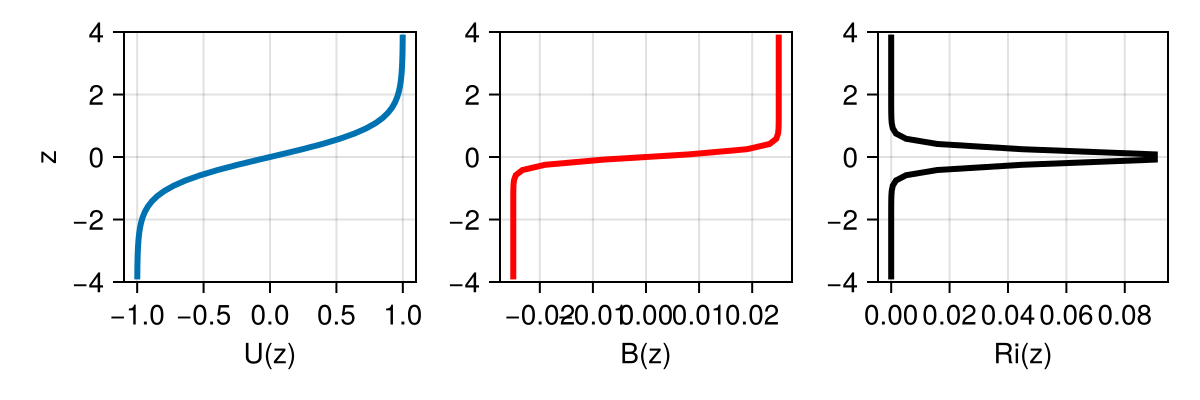

In [4]:
using CairoMakie

zF = znodes(grid, Face())
zC = znodes(grid, Center())

Ri, h = B̄.parameters

fig = Figure(size = (600, 200))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-H/2, H/2)))
lines!(ax, shear_flow.(0, 0, zC, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-H/2, H/2)))
lines!(ax, [stratification(0, 0, z, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((nothing, nothing), (-H/2, H/2)))
lines!(ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zC], zC, linewidth = 3, color = :black) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand

fig

In [5]:
model = NonhydrostaticModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                               coriolis = nothing,
                      background_fields = (u=Ū, b=B̄),
                                closure = ScalarDiffusivity(ν=0.2e-4, κ=0.2e-4),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 60×1×48 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── tracers: b
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=2.0e-5, κ=(b=2.0e-5,))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: Nothing

In [6]:
Δt = 0.1
simulation = Simulation(model, Δt=Δt, stop_time=500, verbose=false)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 100 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 8.333 minutes
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [7]:
using Random, Statistics

u, v, w = model.velocities
b = model.tracers.b
B = Field(model.tracers.b + model.background_fields.tracers.b)
xb, yb, zb = nodes(b)

noise(x, y, z) = 1.e-5*randn()
set!(model, u=noise, w=noise, b=noise)

In [8]:
U = Field(u + model.background_fields.velocities.u)
V = v # No background y-velocity [Flat, so actually no perturbation y-velocity either]
W = w # No background z-velocity
kinetic_energy = @at (Center, Center, Center) 1/2 * (U^2 + V^2 + W^2);

In [9]:
# Copied from https://github.com/tomchor/Oceanostics.jl/blob/main/src/PotentialEnergyEquationTerms.jl
# We should eventually just use Tomas' package but it has strict constraint of Oceananigans.jl@v0.91.0

using Oceananigans.AbstractOperations: KernelFunctionOperation
using Oceananigans.Grids: Center
using Oceananigans.BuoyancyModels: Zᶜᶜᶜ

@inline function PotentialEnergy(model)
    
    B = Field(model.tracers.b + model.background_fields.tracers.b)
    grid = model.grid
    
    return KernelFunctionOperation{Center, Center, Center}(bz_ccc, grid, B)
end

@inline bz_ccc(i, j, k, grid, b) = - b[i, j, k] * Zᶜᶜᶜ(i, j, k, grid)

potential_energy = PotentialEnergy(model)

KernelFunctionOperation at (Center, Center, Center)
├── grid: 60×1×48 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── kernel_function: bz_ccc (generic function with 1 method)
└── arguments: ("60×1×48 Field{Center, Center, Center} on RectilinearGrid on CPU",)

In [10]:
simulation.output_writers[:buoyancy] =
    JLD2OutputWriter(model, (b=b, B=B, KE=kinetic_energy, PE=potential_energy),
                     schedule = TimeInterval(1.0),
                     filename = "../output/stratified_shear_data/example.jld2",
                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(1 second):
├── filepath: ./../output/stratified_shear_data/example.jld2
├── 4 outputs: (b, B, KE, PE)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [ ]:
@info "*** Running a simulation of Kelvin-Helmholtz instability..."
run!(simulation)

In [ ]:
using Printf

@info "Making a neat movie of stratified shear flow..."

filepath = simulation.output_writers[:buoyancy].filepath

B = FieldTimeSeries(filepath, "B")

times = B.times
t_final = times[end]

n = Observable(1)

Bₙ = @lift interior(B, :, 1, :, $n)

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("buoyancy [m/s²] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, interior(B, :, 1, :, :)), maximum(abs, interior(B, :, 1, :, :)))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../animations/shear_instability_example.mp4", frames, framerate=8) do i
    n[] = i
end

### Brute-force computation of Background Potential Energy by directly computing the reference elevation $z_{*}$

We approximate
\begin{equation}
z^{\star}_{i,j,k} = \frac{\int H dV}{A} \simeq A^{-1} \sum_{i,j,k} H_{i,j,k;\,i',j',k'}(b_{i,j,k} - b_{i',j',k'})
\end{equation}

##### Using the above method, let's create a function z$\star$ (`z\bigstar` + `Tab`), which will return zstar for our buoyancy data

In [26]:
using Oceananigans: xspacings, yspacings, zspacings

In [27]:
function ComputeZstar(grid, B)
    x, y, z = nodes(b)
    
    Δx = xspacings(grid, Center())
    Δy = yspacings(grid, Center())
    Δz = zspacings(grid, Center())
    ΔA = Δx * Δy
    ΔV = ΔA * Δz
    
    zstar = zeros(size(B))
    for (i,x0) in enumerate(x)
        for (j,y0) in enumerate(y)
            for (k,z0) in enumerate(z)
                heavyside = B .< reshape(B[i,j,k,:], (1,1,1,size(B,4)))
                zstar[i,j,k,:] = (
                    sum(heavyside .* ΔV, dims=(1,2,3)) ./
                    sum(ones(size(B)[1:2]) .* ΔA)
                ) .+ grid.zᵃᵃᶠ[1]
            end
        end
    end
    
    return zstar
end


ComputeZstar (generic function with 1 method)

In [ ]:
zstar = ComputeZstar(grid, B);

In [ ]:
f1 = Figure()
ax1 = Axis(f1[1,1],title="Heatmap for zstar", xlabel="x[m]", ylabel="z[m]", limits=((-L/2, L/2), (-H/2, H/2)))
hm = heatmap!(ax1, xb, zb, zstar[:,1,:,140]; colorrange = (-H/2, H/2))
Colorbar(f1[1, 2], hm);
f1

In [ ]:
maximum(Zstar)

In [ ]:
minimum(Zstar)

### Let's compute Total, Background, and Available potential energies

$E_p = \int_V -b \cdot z dV $

$E_b = \int_V -b \cdot  z_* dV$

where $ dV = dx dy dz $

### we can use a similar method as the integral of the heaviside was calculated earlier

$ \Delta V = \Delta x \cdot \Delta y \cdot \Delta z  $

In [ ]:
Δx = xspacings(grid, Center())
Δy = yspacings(grid, Center())
Δz = zspacings(grid, Center())
ΔV = Δx * Δy * Δz;

In [ ]:
z_broadcasted = reshape(zb,(1,1,Nz))
potential_energy_offline = sum(-interior(B) .* z_broadcasted .* ΔV, dims=(1,2,3))[1,1,1,:];
background_potential_energy_offline = sum(-interior(B) .* zstar .* ΔV, dims=(1,2,3))[1,1,1,:];

In [21]:
KE_timeseries = FieldTimeSeries(filepath, "KE")
PE_timeseries = FieldTimeSeries(filepath, "PE")

times = B.times

kinetic_energy = zeros(size(times))
potential_energy = zeros(size(times))

for i = 1:length(times)
    ke_snapshot = Field(Integral(KE_timeseries[i]))
    compute!(ke_snapshot)
    kinetic_energy[i] = ke_snapshot[1,1,1]

    pe_snapshot = Field(Integral(PE_timeseries[i]))
    compute!(pe_snapshot)
    potential_energy[i] = pe_snapshot[1,1,1]
end


In [22]:
available_potential_energy = potential_energy_offline .- background_potential_energy_offline;

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/t7ZrV/src/scenes.jl:227


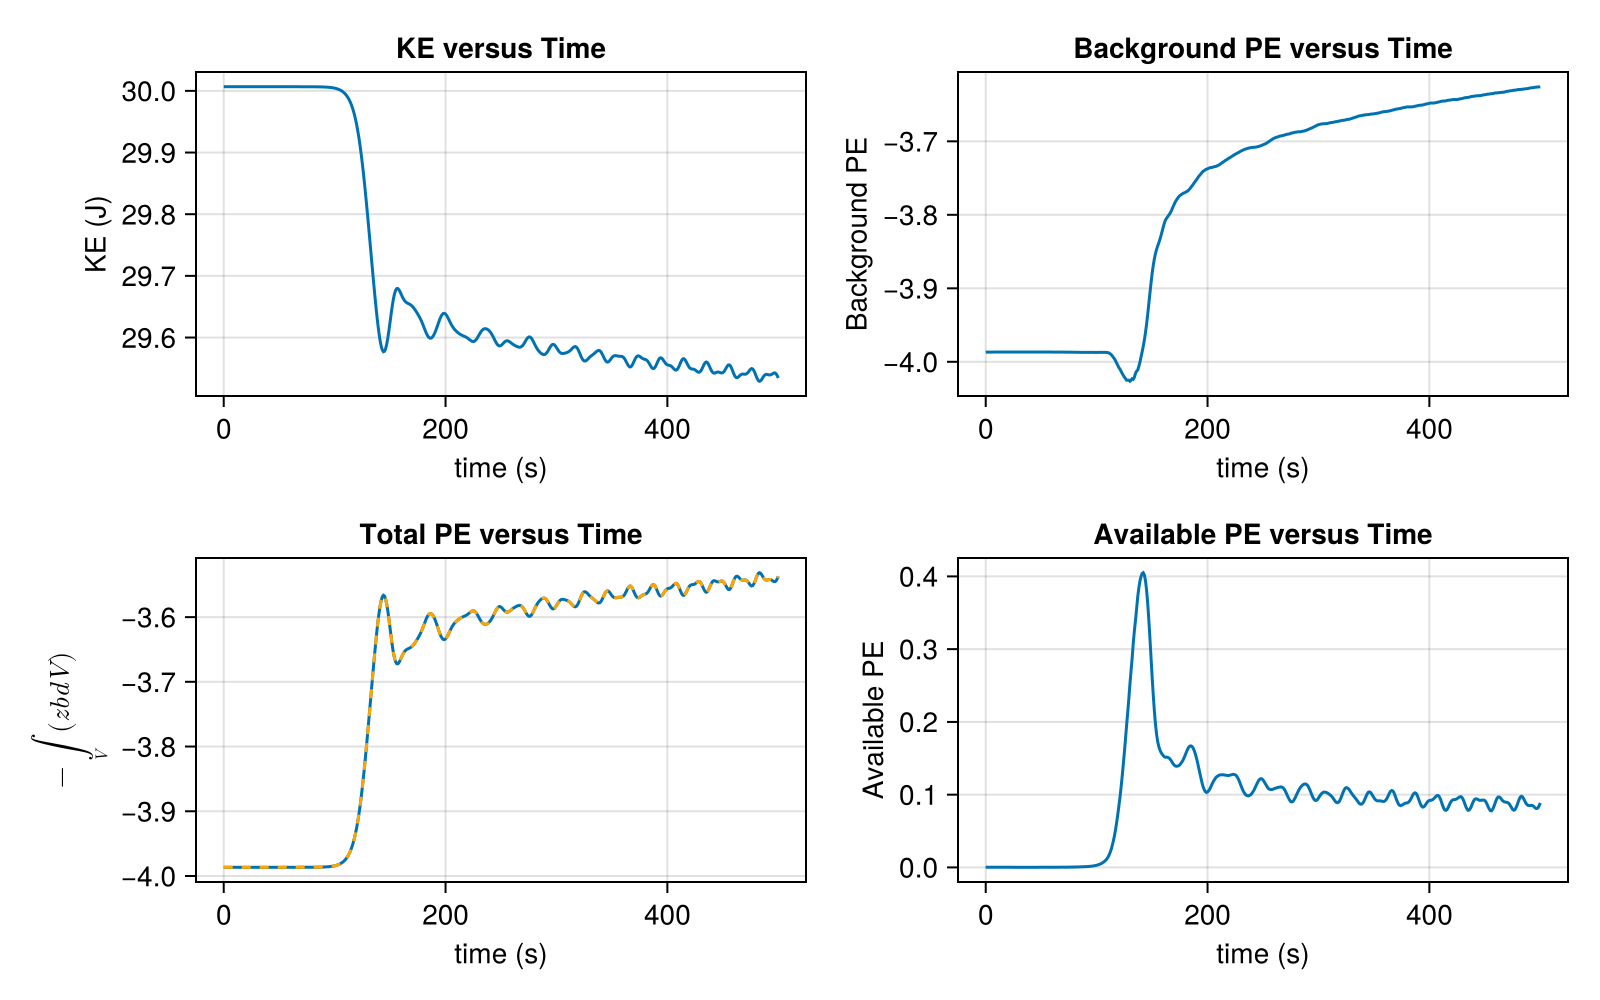

In [23]:
fig_energy = Figure(resolution = (800,500))
ax_KE = Axis(fig_energy[1,1], xlabel = "time (s)", ylabel= "KE (J)", title = "KE versus Time")
lines!(ax_KE, times, kinetic_energy)

ax_PE = Axis(fig_energy[2,1], xlabel= "time (s)", ylabel = L"-\int_V(zbdV)", title = "Total PE versus Time")
lines!(ax_PE, times, potential_energy)
lines!(ax_PE, times, potential_energy_offline, color="orange", linestyle=:dash)

ax_PEb = Axis(fig_energy[1,2], xlabel="time (s)", ylabel="Background PE", title="Background PE versus Time")
lines!(ax_PEb, times, background_potential_energy_offline)

ax_PEa = Axis(fig_energy[2,2], xlabel="time (s)", ylabel="Available PE", title="Available PE versus Time")
lines!(ax_PEa, times, available_potential_energy)

fig_energy